# Social Choice Theory Tutorial: PRISM Dataset Analysis

**5 Preference Aggregation Methods**

This notebook demonstrates how to apply 5 key aggregation methods from social choice theory to analyze AI model preferences in the PRISM dataset.

---

## Overview

**Methods Implemented:**
1. **Pairwise Majority Voting (Condorcet)** - Compare models head-to-head
2. **Borda Count** - Rank-based scoring system  
3. **Plurality Rule** - Highest average score wins
4. **Approval Voting** - Count approvals above threshold
5. **Utilitarian Aggregation** - Maximize total welfare

---

**Key Theoretical Results:**
- Arrow's Impossibility Theorem
- Condorcet's Paradox  
- Gibbard-Satterthwaite Theorem
- May's Characterization of Majority Rule

## Setup

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import defaultdict
import warnings
import ast
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


## 1. Load and Explore Your PRISM Data

In [2]:
df = pd.read_csv('subset.csv')

model_name_map = {
    'Zephyr': 'Zephyr',
    'timdettmers/guanaco-33b-merged': 'Guanaco-33B',
    'models/chat-bison-001': 'PaLM 2',
    'tiiuae/falcon-7b-instruct': 'Falcon-7B',
    'Claude 1': 'Claude 1',
    'Claude 2.1': 'Claude 2.1',
    'gpt-4-1106-preview': 'GPT-4 Turbo',
    'mistralai/Mistral-7B-Instruct-v0.1': 'Mistral-7B',
    'Command': 'Cohere Command',
    'luminous-extended-control': 'Luminous Extended',
    'gpt-3.5-turbo': 'GPT-3.5',
    'meta-llama/Llama-2-13b-chat-hf': 'Llama-2-13B',
    'command-nightly': 'Cohere Nightly',
    'command-light': 'Cohere Light',
    'google/flan-t5-xxl': 'FLAN-T5',
    'meta-llama/Llama-2-7b-chat-hf': 'Llama-2-7B',
    'Claude 2': 'Claude 2',
    'Pythia': 'Pythia',
    'gpt-4': 'GPT-4',
    'meta-llama/Llama-2-70b-chat-hf': 'Llama-2-70B',
    'luminous-supreme-control': 'Luminous Supreme',
    'HuggingFaceH4/zephyr-7b-beta': 'Zephyr-7B',
    'OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5': 'OASST-12B',
}
df['model_name'] = df['model_name'].replace(model_name_map)
df['ethnicity'] = df['ethnicity'].apply(lambda x: ast.literal_eval(x)['categorised'] if isinstance(x, str) else x)
df.head(5)

,user_id,score,model_name,gender,ethnicity,age,location
0,user7,88,Zephyr-7B,Female,Prefer not to say,18-24 years old,US
1,user7,13,Guanaco-33B,Female,Prefer not to say,18-24 years old,US
2,user7,75,PaLM 2,Female,Prefer not to say,18-24 years old,US
3,user7,69,Falcon-7B,Female,Prefer not to say,18-24 years old,US
4,user7,74,claude-instant-1,Female,Prefer not to say,18-24 years old,US


In [3]:
# Summary statistics
print("Score Statistics:")
print(df['score'].describe())

print("\n" + "="*60)
print("Demographics Distribution")
print("="*60)

for col in ['gender', 'age', 'ethnicity']:
    print(f"\n{col.upper()}:")
    print(df[col].value_counts())

Score Statistics:
count    6407.000000
mean       59.141252
std        31.895467
min         1.000000
25%        35.000000
50%        66.000000
75%        86.000000
max       100.000000
Name: score, dtype: float64

Demographics Distribution

GENDER:
gender
Male                         3245
Female                       3039
Non-binary / third gender     115
Prefer not to say               8
Name: count, dtype: int64

AGE:
age
55-64 years old    1500
25-34 years old    1248
45-54 years old    1195
35-44 years old    1026
65+ years old       838
18-24 years old     600
Name: count, dtype: int64

ETHNICITY:
ethnicity
White                         4762
Mixed                          404
Black / African                396
Hispanic / Latino              323
Prefer not to say              298
Asian                          201
Indigenous / First Peoples      23
Name: count, dtype: int64


## Method 1: Pairwise Majority Voting (Condorcet)

**Concept:** Compare each pair of models. Model A beats Model B if more users who rated both prefer A to B.

**Winner:** Model that beats all others in pairwise comparisons (Condorcet winner)

**Theory:** This can detect **Condorcet's Paradox** - cyclical preferences where A>B>C>A

In [4]:
def condorcet_pairwise_comparison(df, model_a, model_b):
    """Compare two models using pairwise majority voting"""
    users_a = set(df[df['model_name'] == model_a]['user_id'])
    users_b = set(df[df['model_name'] == model_b]['user_id'])
    common_users = users_a & users_b
    
    if len(common_users) == 0:
        return 0, 0, 0
    
    votes_a, votes_b, ties = 0, 0, 0
    
    for user in common_users:
        score_a = df[(df['user_id'] == user) & (df['model_name'] == model_a)]['score'].iloc[0]
        score_b = df[(df['user_id'] == user) & (df['model_name'] == model_b)]['score'].iloc[0]
        
        if score_a > score_b:
            votes_a += 1
        elif score_b > score_a:
            votes_b += 1
        else:
            ties += 1
    
    return votes_a, votes_b, ties


def condorcet_method(df):
    """Apply Condorcet method (pairwise majority voting)"""
    print("="*80)
    print("METHOD 1: PAIRWISE MAJORITY VOTING (CONDORCET)")
    print("="*80)
    
    models = sorted(df['model_name'].unique())
    n_models = len(models)
    
    # Pairwise comparison matrix
    comparison_matrix = pd.DataFrame(
        np.zeros((n_models, n_models)),
        index=models,
        columns=models
    )
    
    print("\n--- Pairwise Comparisons ---")
    for model_a, model_b in combinations(models, 2):
        votes_a, votes_b, ties = condorcet_pairwise_comparison(df, model_a, model_b)
        
        if votes_a + votes_b + ties > 0:
            print(f"\n{model_a} vs {model_b}:")
            print(f"  {model_a}: {votes_a} votes ({votes_a/(votes_a+votes_b+ties)*100:.1f}%)")
            print(f"  {model_b}: {votes_b} votes ({votes_b/(votes_a+votes_b+ties)*100:.1f}%)")
            print(f"  Ties: {ties}")
            
            if votes_a > votes_b:
                comparison_matrix.loc[model_a, model_b] = 1
                print(f"  → Winner: {model_a}")
            elif votes_b > votes_a:
                comparison_matrix.loc[model_b, model_a] = 1
                print(f"  → Winner: {model_b}")
    
    # Count wins
    wins = comparison_matrix.sum(axis=1).sort_values(ascending=False)
    
    print(f"\n--- Win Counts ---")
    for model, win_count in wins.items():
        print(f"{model}: {int(win_count)} pairwise wins")
    
    # Check for Condorcet winner
    condorcet_winner = None
    for model in models:
        if comparison_matrix.loc[model].sum() == n_models - 1:
            condorcet_winner = model
            print(f"\n🏆 CONDORCET WINNER: {condorcet_winner}")
            break
    
    if condorcet_winner is None:
        print(f"\n⚠️  NO CONDORCET WINNER - Potential cyclical preferences!")
        print(f"    Top by wins: {wins.index[0]} ({int(wins.iloc[0])} wins)")
    
    return {
        'method': 'Condorcet',
        'winner': condorcet_winner if condorcet_winner else wins.index[0],
        'ranking': wins.index.tolist(),
        'comparison_matrix': comparison_matrix
    }


# Run Condorcet method
condorcet_result = condorcet_method(df)

METHOD 1: PAIRWISE MAJORITY VOTING (CONDORCET)

--- Pairwise Comparisons ---

Cohere Light vs Cohere Nightly:
  Cohere Light: 62 votes (41.6%)
  Cohere Nightly: 77 votes (51.7%)
  Ties: 10
  → Winner: Cohere Nightly

Cohere Light vs FLAN-T5:
  Cohere Light: 114 votes (78.6%)
  FLAN-T5: 22 votes (15.2%)
  Ties: 9
  → Winner: Cohere Light

Cohere Light vs Falcon-7B:
  Cohere Light: 78 votes (56.9%)
  Falcon-7B: 51 votes (37.2%)
  Ties: 8
  → Winner: Cohere Light

Cohere Light vs GPT-3.5:
  Cohere Light: 77 votes (48.1%)
  GPT-3.5: 78 votes (48.8%)
  Ties: 5
  → Winner: GPT-3.5

Cohere Light vs GPT-4:
  Cohere Light: 61 votes (44.2%)
  GPT-4: 71 votes (51.4%)
  Ties: 6
  → Winner: GPT-4

Cohere Light vs GPT-4 Turbo:
  Cohere Light: 71 votes (49.0%)
  GPT-4 Turbo: 70 votes (48.3%)
  Ties: 4
  → Winner: Cohere Light

Cohere Light vs Guanaco-33B:
  Cohere Light: 75 votes (49.0%)
  Guanaco-33B: 72 votes (47.1%)
  Ties: 6
  → Winner: Cohere Light

Cohere Light vs Llama-2-13B:
  Cohere Light: 4

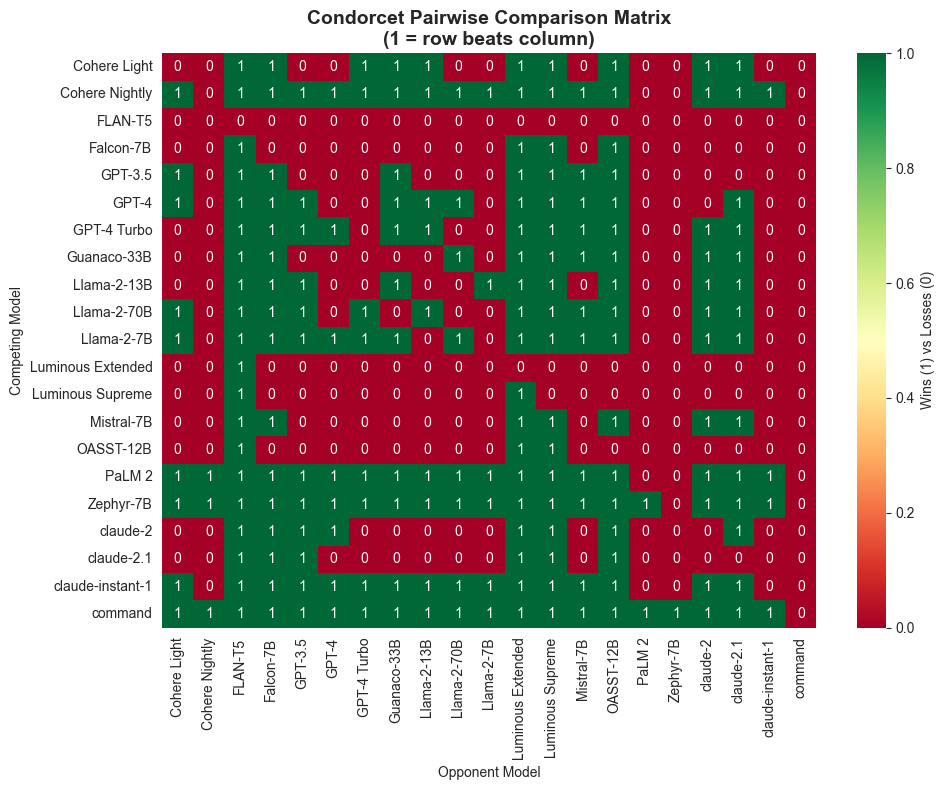

In [5]:
# Visualize pairwise comparison matrix
plt.figure(figsize=(10, 8))
sns.heatmap(condorcet_result['comparison_matrix'], annot=True, fmt='g', 
            cmap='RdYlGn', cbar_kws={'label': 'Wins (1) vs Losses (0)'})
plt.title('Condorcet Pairwise Comparison Matrix\n(1 = row beats column)', fontsize=14, fontweight='bold')
plt.xlabel('Opponent Model')
plt.ylabel('Competing Model')
plt.tight_layout()
plt.show()

## Method 2: Borda Count

**Concept:** Each user ranks models by score. Top model gets k points, second gets k-1, etc.

**Winner:** Model with highest total Borda score

**Theory:** Violates independence of irrelevant alternatives. Vulnerable to strategic manipulation (Gibbard-Satterthwaite).

In [6]:
def borda_count(df):
    """Apply Borda Count method"""
    print("="*80)
    print("METHOD 2: BORDA COUNT")
    print("="*80)
    
    borda_scores = defaultdict(float)
    user_rankings_count = defaultdict(int)
    
    # For each user, rank their models
    for user_id in df['user_id'].unique():
        user_data = df[df['user_id'] == user_id].copy()
        user_data = user_data.sort_values('score', ascending=False).reset_index(drop=True)
        
        n_models_rated = len(user_data)
        for rank, row in user_data.iterrows():
            model = row['model_name']
            borda_points = n_models_rated - rank
            borda_scores[model] += borda_points
            user_rankings_count[model] += 1
    
    # Convert to DataFrame
    borda_df = pd.DataFrame([
        {
            'model': model, 
            'borda_score': score,
            'times_ranked': user_rankings_count[model],
            'avg_borda_score': score / user_rankings_count[model]
        }
        for model, score in borda_scores.items()
    ]).sort_values('borda_score', ascending=False).reset_index(drop=True)
    
    print("\n--- Borda Scores ---")
    for idx, row in borda_df.iterrows():
        print(f"{idx+1}. {row['model']:<15} | Total: {row['borda_score']:.0f} | "
              f"Ranked by: {row['times_ranked']} users | Avg: {row['avg_borda_score']:.2f}")
    
    print(f"\n🏆 BORDA WINNER: {borda_df.iloc[0]['model']}")
    
    return {
        'method': 'Borda Count',
        'winner': borda_df.iloc[0]['model'],
        'ranking': borda_df['model'].tolist(),
        'scores': borda_df
    }


# Run Borda Count
borda_result = borda_count(df)

METHOD 2: BORDA COUNT

--- Borda Scores ---
1. command         | Total: 4800 | Ranked by: 325 users | Avg: 14.77
2. claude-instant-1 | Total: 4719 | Ranked by: 344 users | Avg: 13.72
3. Llama-2-7B      | Total: 4429 | Ranked by: 338 users | Avg: 13.10
4. PaLM 2          | Total: 4360 | Ranked by: 329 users | Avg: 13.25
5. Cohere Nightly  | Total: 4174 | Ranked by: 316 users | Avg: 13.21
6. GPT-4 Turbo     | Total: 4124 | Ranked by: 327 users | Avg: 12.61
7. GPT-3.5         | Total: 4100 | Ranked by: 342 users | Avg: 11.99
8. Cohere Light    | Total: 4098 | Ranked by: 335 users | Avg: 12.23
9. GPT-4           | Total: 3940 | Ranked by: 323 users | Avg: 12.20
10. Zephyr-7B       | Total: 3879 | Ranked by: 290 users | Avg: 13.38
11. Guanaco-33B     | Total: 3849 | Ranked by: 326 users | Avg: 11.81
12. claude-2        | Total: 3706 | Ranked by: 325 users | Avg: 11.40
13. claude-2.1      | Total: 3603 | Ranked by: 329 users | Avg: 10.95
14. Llama-2-70B     | Total: 3594 | Ranked by: 276 use

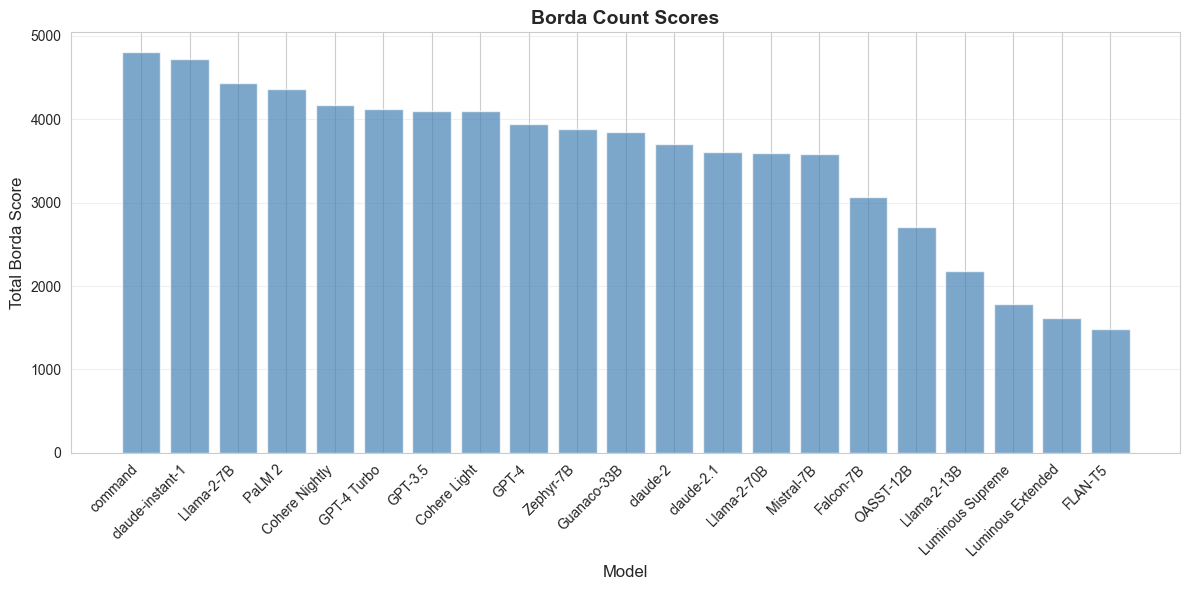

In [7]:
# Visualize Borda scores
plt.figure(figsize=(12, 6))
scores_df = borda_result['scores']
plt.bar(scores_df['model'], scores_df['borda_score'], color='steelblue', alpha=0.7)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Total Borda Score', fontsize=12)
plt.title('Borda Count Scores', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Method 3: Plurality Rule (Highest Average Score)

**Concept:** Model with highest average score across all users wins

**Winner:** Model with highest mean score

**Theory:** Simple and intuitive, but can elect majority-dispreferred models

In [8]:
def plurality_rule(df):
    """Apply Plurality Rule (highest average score)"""
    print("="*80)
    print("METHOD 3: PLURALITY RULE (HIGHEST AVERAGE SCORE)")
    print("="*80)
    
    model_stats = df.groupby('model_name').agg({
        'score': ['mean', 'std', 'count', 'median']
    }).round(2)
    
    model_stats.columns = ['mean_score', 'std_score', 'n_ratings', 'median_score']
    model_stats = model_stats.sort_values('mean_score', ascending=False).reset_index()
    
    print("\n--- Average Scores ---")
    for idx, row in model_stats.iterrows():
        print(f"{idx+1}. {row['model_name']:<15} | Mean: {row['mean_score']:.2f} ± {row['std_score']:.2f} | "
              f"Median: {row['median_score']:.1f} | N: {int(row['n_ratings'])}")
    
    print(f"\n🏆 PLURALITY WINNER: {model_stats.iloc[0]['model_name']}")
    
    return {
        'method': 'Plurality Rule',
        'winner': model_stats.iloc[0]['model_name'],
        'ranking': model_stats['model_name'].tolist(),
        'scores': model_stats
    }


# Run Plurality Rule
plurality_result = plurality_rule(df)

METHOD 3: PLURALITY RULE (HIGHEST AVERAGE SCORE)

--- Average Scores ---
1. command         | Mean: 70.50 ± 29.89 | Median: 81.0 | N: 325
2. claude-instant-1 | Mean: 70.18 ± 24.92 | Median: 74.5 | N: 344
3. PaLM 2          | Mean: 68.16 ± 27.63 | Median: 74.0 | N: 329
4. Llama-2-70B     | Mean: 67.78 ± 28.69 | Median: 76.0 | N: 276
5. Llama-2-7B      | Mean: 67.21 ± 28.53 | Median: 74.0 | N: 338
6. GPT-4 Turbo     | Mean: 66.41 ± 25.37 | Median: 71.0 | N: 327
7. Cohere Nightly  | Mean: 66.36 ± 29.05 | Median: 74.0 | N: 316
8. Zephyr-7B       | Mean: 66.23 ± 29.38 | Median: 75.0 | N: 290
9. GPT-4           | Mean: 64.68 ± 27.10 | Median: 71.0 | N: 323
10. Llama-2-13B     | Mean: 63.72 ± 29.91 | Median: 72.0 | N: 181
11. GPT-3.5         | Mean: 62.75 ± 26.85 | Median: 66.0 | N: 342
12. Cohere Light    | Mean: 62.03 ± 31.63 | Median: 71.0 | N: 335
13. Mistral-7B      | Mean: 60.55 ± 27.09 | Median: 64.0 | N: 319
14. Guanaco-33B     | Mean: 60.45 ± 32.68 | Median: 70.5 | N: 326
15. claude-

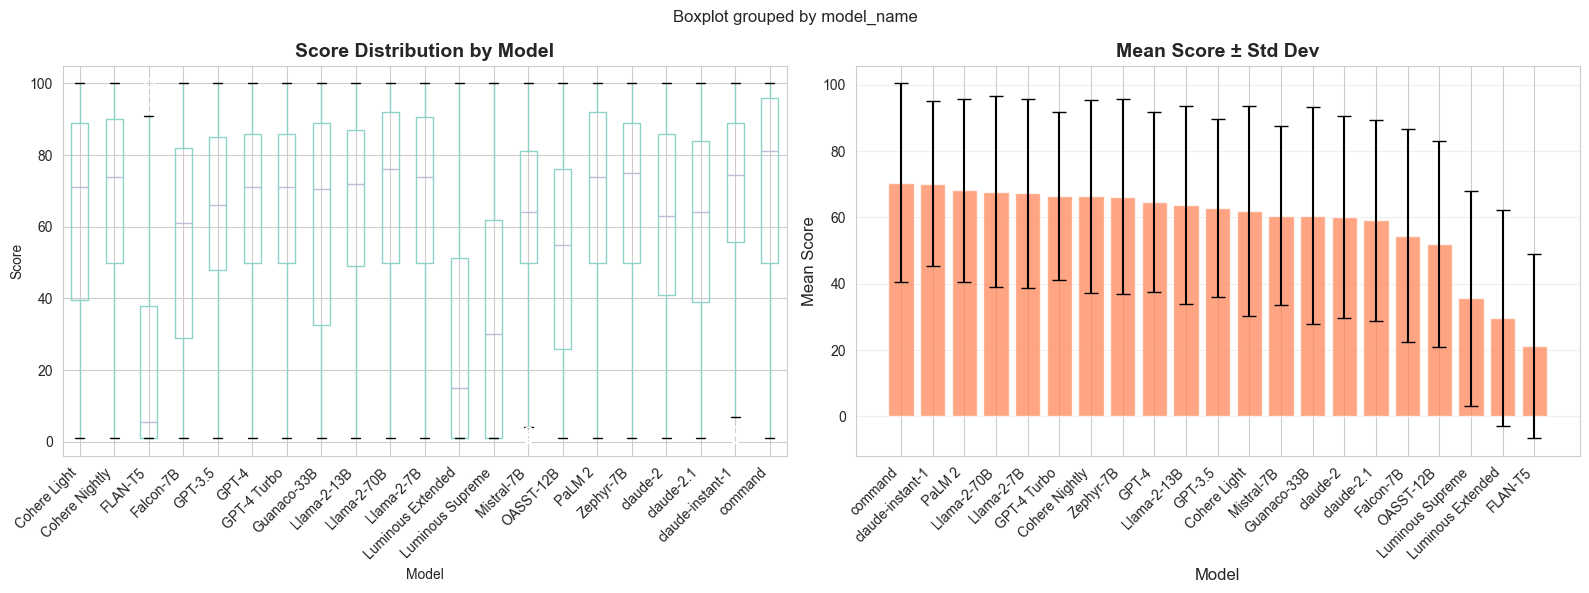

In [9]:
# Visualize score distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
df.boxplot(column='score', by='model_name', ax=ax1)
ax1.set_title('Score Distribution by Model', fontsize=14, fontweight='bold')
ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
plt.sca(ax1)
plt.xticks(rotation=45, ha='right')

# Bar chart with error bars
stats = plurality_result['scores']
ax2.bar(stats['model_name'], stats['mean_score'], 
        yerr=stats['std_score'], capsize=5, alpha=0.7, color='coral')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Mean Score', fontsize=12)
ax2.set_title('Mean Score ± Std Dev', fontsize=14, fontweight='bold')
ax2.set_xticklabels(stats['model_name'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Method 4: Approval Voting

**Concept:** Users "approve" models with score > threshold (e.g., 70)

**Winner:** Model with most approvals

**Theory:** Strategy-proof for dichotomous preferences

In [10]:
def approval_voting(df, threshold=70):
    """Apply Approval Voting"""
    print("="*80)
    print(f"METHOD 4: APPROVAL VOTING (Threshold: {threshold})")
    print("="*80)
    
    df['approved'] = df['score'] > threshold
    
    approval_counts = df.groupby('model_name').agg({
        'approved': 'sum',
        'score': 'count'
    }).rename(columns={'approved': 'approvals', 'score': 'total_ratings'})
    
    approval_counts['approval_rate'] = (
        approval_counts['approvals'] / approval_counts['total_ratings'] * 100
    ).round(1)
    
    approval_counts = approval_counts.sort_values('approvals', ascending=False).reset_index()
    
    print("\n--- Approval Counts ---")
    for idx, row in approval_counts.iterrows():
        print(f"{idx+1}. {row['model_name']:<15} | Approvals: {int(row['approvals']):>3} / "
              f"{int(row['total_ratings']):>3} ({row['approval_rate']:.1f}%)")
    
    print(f"\n🏆 APPROVAL WINNER: {approval_counts.iloc[0]['model_name']}")
    
    return {
        'method': 'Approval Voting',
        'winner': approval_counts.iloc[0]['model_name'],
        'ranking': approval_counts['model_name'].tolist(),
        'scores': approval_counts,
        'threshold': threshold
    }


# Run Approval Voting
approval_result = approval_voting(df, threshold=70)

METHOD 4: APPROVAL VOTING (Threshold: 70)

--- Approval Counts ---
1. command         | Approvals: 198 / 325 (60.9%)
2. claude-instant-1 | Approvals: 193 / 344 (56.1%)
3. Llama-2-7B      | Approvals: 184 / 338 (54.4%)
4. PaLM 2          | Approvals: 180 / 329 (54.7%)
5. Cohere Nightly  | Approvals: 178 / 316 (56.3%)
6. Cohere Light    | Approvals: 169 / 335 (50.4%)
7. GPT-4           | Approvals: 165 / 323 (51.1%)
8. GPT-4 Turbo     | Approvals: 164 / 327 (50.2%)
9. Guanaco-33B     | Approvals: 163 / 326 (50.0%)
10. Zephyr-7B       | Approvals: 156 / 290 (53.8%)
11. GPT-3.5         | Approvals: 153 / 342 (44.7%)
12. Llama-2-70B     | Approvals: 151 / 276 (54.7%)
13. claude-2.1      | Approvals: 140 / 329 (42.6%)
14. claude-2        | Approvals: 134 / 325 (41.2%)
15. Mistral-7B      | Approvals: 134 / 319 (42.0%)
16. Falcon-7B       | Approvals: 113 / 300 (37.7%)
17. Llama-2-13B     | Approvals:  94 / 181 (51.9%)
18. OASST-12B       | Approvals:  90 / 277 (32.5%)
19. Luminous Supreme | 

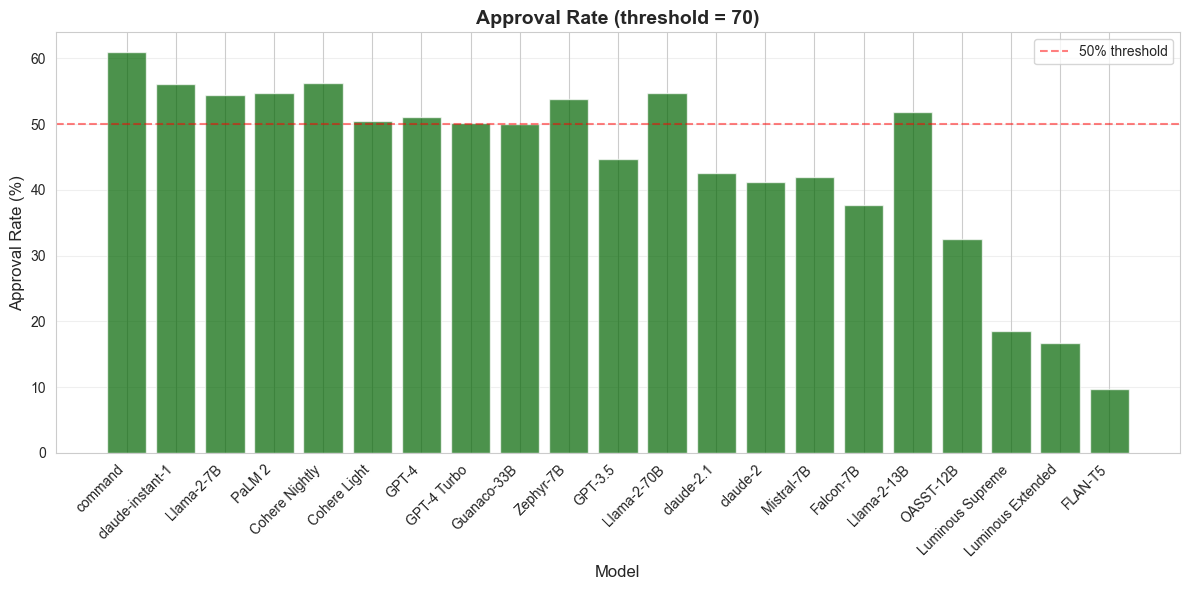

In [11]:
# Visualize approval rates
plt.figure(figsize=(12, 6))
approval_data = approval_result['scores']
plt.bar(approval_data['model_name'], approval_data['approval_rate'], 
        color='darkgreen', alpha=0.7)
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% threshold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Approval Rate (%)', fontsize=12)
plt.title(f'Approval Rate (threshold = {approval_result["threshold"]})', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Method 5: Utilitarian Aggregation

**Concept:** Maximize total welfare - model with highest sum of scores wins

**Winner:** Model with highest sum of all scores

**Theory:** Classic utilitarian principle. Requires cardinal utility with interpersonal comparability.

In [12]:
def utilitarian_aggregation(df):
    """Apply Utilitarian Aggregation"""
    print("="*80)
    print("METHOD 5: UTILITARIAN AGGREGATION")
    print("="*80)
    
    utilitarian_scores = df.groupby('model_name').agg({
        'score': ['sum', 'mean', 'count']
    })
    
    utilitarian_scores.columns = ['total_score', 'mean_score', 'n_ratings']
    utilitarian_scores = utilitarian_scores.sort_values('total_score', ascending=False).reset_index()
    
    print("\n--- Total Scores (Utilitarian Welfare) ---")
    for idx, row in utilitarian_scores.iterrows():
        print(f"{idx+1}. {row['model_name']:<15} | Total: {row['total_score']:.0f} | "
              f"Mean: {row['mean_score']:.2f} | N: {int(row['n_ratings'])}")
    
    print(f"\n🏆 UTILITARIAN WINNER: {utilitarian_scores.iloc[0]['model_name']}")
    
    return {
        'method': 'Utilitarian',
        'winner': utilitarian_scores.iloc[0]['model_name'],
        'ranking': utilitarian_scores['model_name'].tolist(),
        'scores': utilitarian_scores
    }


# Run Utilitarian Aggregation
utilitarian_result = utilitarian_aggregation(df)

METHOD 5: UTILITARIAN AGGREGATION

--- Total Scores (Utilitarian Welfare) ---
1. claude-instant-1 | Total: 24142 | Mean: 70.18 | N: 344
2. command         | Total: 22912 | Mean: 70.50 | N: 325
3. Llama-2-7B      | Total: 22716 | Mean: 67.21 | N: 338
4. PaLM 2          | Total: 22426 | Mean: 68.16 | N: 329
5. GPT-4 Turbo     | Total: 21717 | Mean: 66.41 | N: 327
6. GPT-3.5         | Total: 21461 | Mean: 62.75 | N: 342
7. Cohere Nightly  | Total: 20971 | Mean: 66.36 | N: 316
8. GPT-4           | Total: 20891 | Mean: 64.68 | N: 323
9. Cohere Light    | Total: 20779 | Mean: 62.03 | N: 335
10. Guanaco-33B     | Total: 19708 | Mean: 60.45 | N: 326
11. claude-2        | Total: 19545 | Mean: 60.14 | N: 325
12. claude-2.1      | Total: 19433 | Mean: 59.07 | N: 329
13. Mistral-7B      | Total: 19317 | Mean: 60.55 | N: 319
14. Zephyr-7B       | Total: 19206 | Mean: 66.23 | N: 290
15. Llama-2-70B     | Total: 18708 | Mean: 67.78 | N: 276
16. Falcon-7B       | Total: 16351 | Mean: 54.50 | N: 300
17

## Compare All Methods

**Key Question:** Do different methods produce different winners?

In [13]:
# Collect all results
all_results = [
    condorcet_result,
    borda_result,
    plurality_result,
    approval_result,
    utilitarian_result
]

# Create comparison table
all_models = sorted(set([model for result in all_results for model in result['ranking']]))

comparison_df = pd.DataFrame({'Model': all_models})

for result in all_results:
    method_name = result['method']
    rankings = {model: rank+1 for rank, model in enumerate(result['ranking'])}
    comparison_df[method_name] = comparison_df['Model'].map(rankings)

# Add winner count
winner_counts = defaultdict(int)
for result in all_results:
    winner_counts[result['winner']] += 1

comparison_df['Wins'] = comparison_df['Model'].map(winner_counts).fillna(0).astype(int)
comparison_df['Avg_Rank'] = comparison_df.iloc[:, 1:-1].mean(axis=1).round(2)

comparison_df = comparison_df.sort_values('Avg_Rank').reset_index(drop=True)

print("="*80)
print("COMPARISON ACROSS ALL METHODS")
print("="*80)
print("\nRankings by Method:")
print(comparison_df.to_string(index=False))

COMPARISON ACROSS ALL METHODS

Rankings by Method:
            Model  Condorcet  Borda Count  Plurality Rule  Approval Voting  Utilitarian  Wins  Avg_Rank
          command          1            1               1                1            2     4       1.2
 claude-instant-1          5            2               2                2            1     1       2.4
           PaLM 2          3            4               3                4            4     0       3.6
       Llama-2-7B          6            3               5                3            3     0       4.0
   Cohere Nightly          4            5               7                5            7     0       5.6
      GPT-4 Turbo          7            6               6                8            5     0       6.4
            GPT-4          9            9               9                7            8     0       8.4
        Zephyr-7B          2           10               8               10           14     0       8.8
     Cohere L

In [14]:
# Check for consensus
unique_winners = set([result['winner'] for result in all_results])

print("\n" + "="*80)
print("WINNER ANALYSIS")
print("="*80)

print("\nWinners by Method:")
for result in all_results:
    print(f"  {result['method']:<25}: {result['winner']}")

if len(unique_winners) == 1:
    print(f"\n✓ CONSENSUS WINNER: {list(unique_winners)[0]}")
    print("  All methods agree!")
else:
    print(f"\n⚠️  NO CONSENSUS - {len(unique_winners)} different winners")
    print("   Different aggregation methods can produce different winners.")
    print("   This is not a bug - it reflects fundamental trade-offs!")


WINNER ANALYSIS

Winners by Method:
  Condorcet                : command
  Borda Count              : command
  Plurality Rule           : command
  Approval Voting          : command
  Utilitarian              : claude-instant-1

⚠️  NO CONSENSUS - 2 different winners

📚 This illustrates ARROW'S IMPOSSIBILITY THEOREM:
   Different aggregation methods can produce different winners.
   This is not a bug - it reflects fundamental trade-offs!


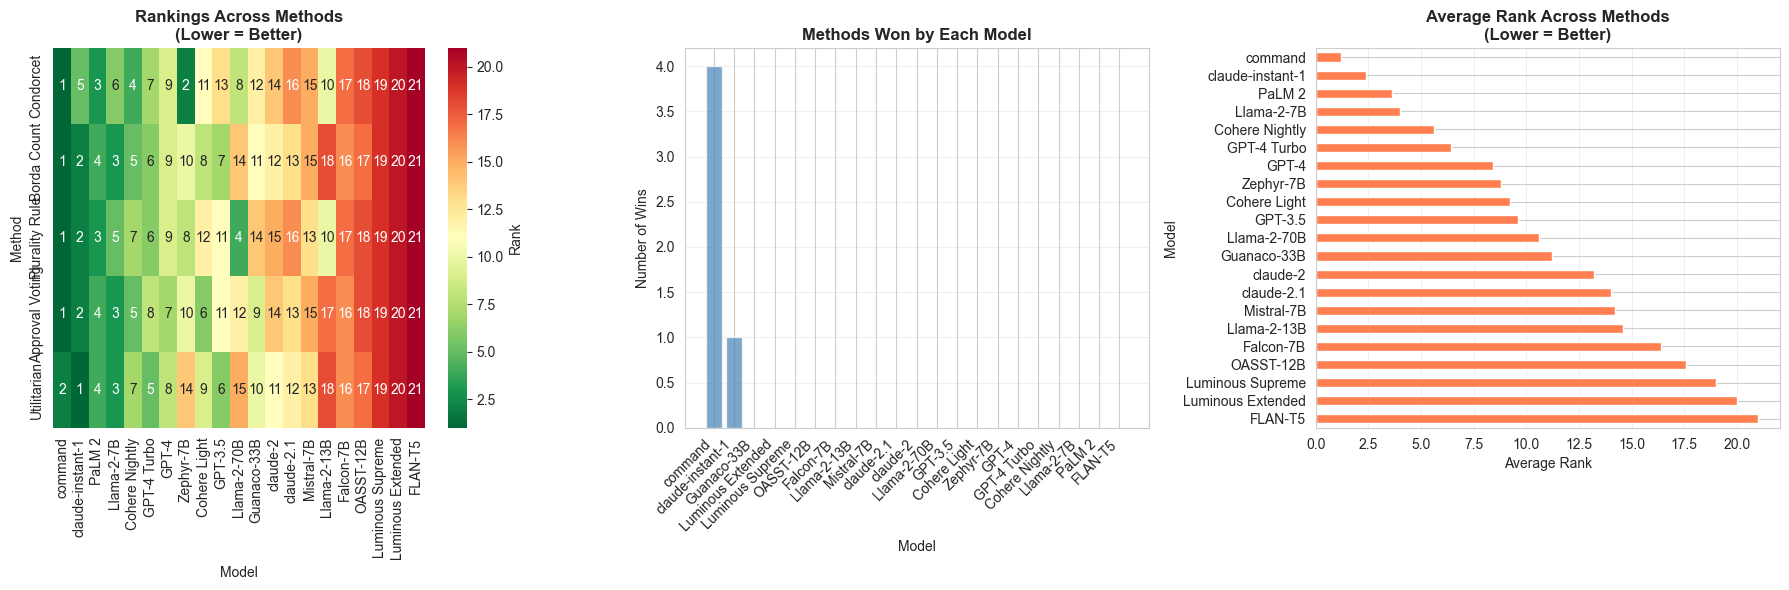

In [15]:
# Visualization: Rankings comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Heatmap of rankings
ax = axes[0]
ranking_data = comparison_df.set_index('Model').iloc[:, :-2]
sns.heatmap(ranking_data.T, annot=True, fmt='g', cmap='RdYlGn_r', 
            ax=ax, cbar_kws={'label': 'Rank'})
ax.set_title('Rankings Across Methods\n(Lower = Better)', fontsize=12, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Method')

# 2. Number of wins
ax = axes[1]
winner_data = comparison_df.sort_values('Wins', ascending=False)
ax.bar(winner_data['Model'], winner_data['Wins'], color='steelblue', alpha=0.7)
ax.set_title('Methods Won by Each Model', fontsize=12, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Number of Wins')
ax.set_xticklabels(winner_data['Model'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# 3. Average rank
ax = axes[2]
comparison_df.sort_values('Avg_Rank').plot(
    x='Model', y='Avg_Rank', kind='barh', ax=ax, color='coral', legend=False
)
ax.set_title('Average Rank Across Methods\n(Lower = Better)', fontsize=12, fontweight='bold')
ax.set_xlabel('Average Rank')
ax.set_ylabel('Model')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights & Theoretical Connections

### Social Choice Theory Concepts Demonstrated:

**1. Arrow's Impossibility Theorem**
- Different methods produce different winners (if they do)
- No aggregation rule satisfies all "reasonable" criteria simultaneously
- Every method makes normative trade-offs

**2. Condorcet's Paradox**  
- Checked if cyclical preferences exist (A>B>C>A)
- Majority preferences can be intransitive even when individual preferences are rational

**3. Gibbard-Satterthwaite Theorem**
- Borda Count is vulnerable to strategic manipulation
- All non-dictatorial rules with ≥3 alternatives are manipulable

**4. No Perfect Method**
- Choice of aggregation method reflects values
- Utilitarian: maximize total satisfaction
- Egalitarian: treat all voters equally (majority rule)
- Approval: respect intensity of preferences